This notebook will be used to identify the best CEBRA model to use with our simple synethetic data

In [1]:
! pip install 'cebra[dev,demos]' 

/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/bin/pip: line 2: /Users/brian.gitahi/Desktop/AIND/CEBRA Analysis/CEBRA13/cebraenv/bin/python: No such file or directory
/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/bin/pip: line 2: exec: /Users/brian.gitahi/Desktop/AIND/CEBRA Analysis/CEBRA13/cebraenv/bin/python: cannot execute: No such file or directory


In [2]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
from scipy.integrate import solve_ivp
import matplotlib.gridspec as gridspec
import cebra.datasets
from cebra import CEBRA
import d_library as dl

from matplotlib.collections import LineCollection
import pandas as pd

/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/lib/python3.11/site-packages/cebra/datasets/__init__.py:103: UserWarning: Could not initialize one or more datasets: No module named 'h5py'. For using the datasets, consider installing the [datasets] extension via pip.
  warnings.warn(f"Could not initialize one or more datasets: {e}. "


## Define Input Data

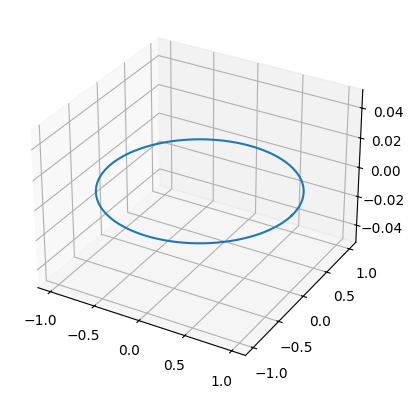

(100, 3)

In [3]:
%matplotlib inline
circle = dl.make_circle()
dl.plot_circle(circle[:,0], circle[:,1])
circle.shape

In [4]:
# define a function to make a lorenz system
def lorenz(t, xyz, sigma=10, rho=28, beta=8/3):
    x, y, z = xyz
    dxdt = sigma * (y - x)
    dydt = rho * x - y - x * z
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]


# Define parameters and initial conditions
sigma = 10
rho = 28
beta = 8/3
initial_conditions = [0, 2, 0]  # Initial conditions for [x, y, z]

# Time span for integration
t_span = [0, 35]

# Solve the differential equations
solution = solve_ivp(lorenz, t_span, initial_conditions, args=(sigma, rho, beta), dense_output=True)

# Generate time points for plotting
t = np.linspace(t_span[0], t_span[1], 10000)

# Evaluate the solution at the time points
xyz = solution.sol(t)

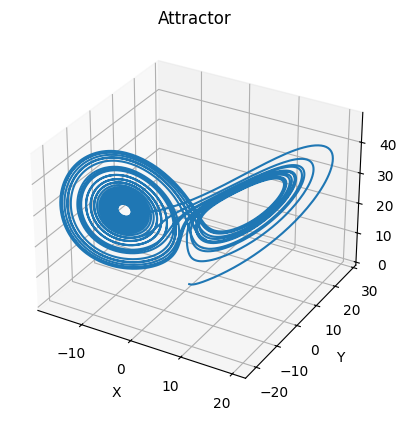

In [5]:
# Plot the Lorenz attractor
def plot_lorenz(coords):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(coords[0], coords[1], coords[2], alpha=1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Attractor')
    plt.show()


plot_lorenz(xyz)

In [6]:
# reshape it for use with cebra
lorenz_obj = xyz.reshape(10000,3)
lorenz_obj.shape

(10000, 3)

## Model Analysis
### 1. Offset1-model

We start with the offset1-model, detailing the steps of the analysis.

In [7]:
iterations = 2000

In [8]:
# build model and compute embedding
def base_embed_1(input, arch = 'offset1-model', temp=1, dimension=3, lr = 0.01, d=0.1):

    # build CEBRA time model
    model = CEBRA(model_architecture=arch,
                         batch_size=512,
                         learning_rate=int(lr),
                         temperature_mode='auto',
                         temperature=int(temp),
                         output_dimension = int(dimension),
                         max_iterations=iterations,
                         distance='euclidean',
                         conditional='time',
                         device='cuda_if_available',
                         num_hidden_units=64,
                         verbose=True,
                         time_offsets=1)

    model.fit(input)
    embedding = model.transform(input)
    return model, embedding

In [9]:
# get embeddings
model_1c, embedding_1c = base_embed_1(circle, lr=0.1)
model_1l, embeddling_1l = base_embed_1(lorenz_obj, lr=0.01)

pos:  0.0000 neg:  6.2310 total:  6.2310 temperature:  1.0000: 100%|██████████| 2000/2000 [00:24<00:00, 80.15it/s]
pos:  0.0044 neg:  5.3951 total:  5.3994 temperature:  1.0000: 100%|██████████| 2000/2000 [00:24<00:00, 82.13it/s]


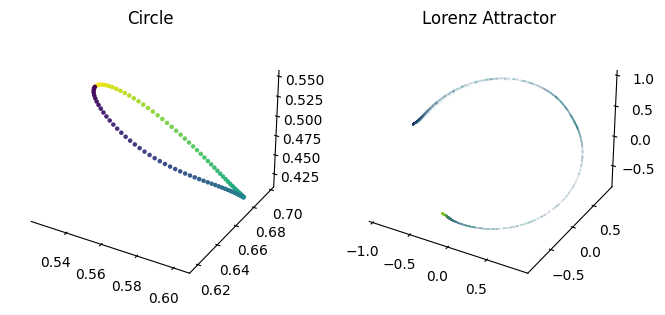

In [10]:
# plot the embeddings
def plot_2embeddings(embed1,embed2):
    fig0 = plt.figure(figsize=(8,4))
    gs = gridspec.GridSpec(1, 2, figure=fig0)

    ax0 = fig0.add_subplot(gs[0,0], projection='3d')
    ax1 = fig0.add_subplot(gs[0,1], projection='3d')
    cebra.plot_embedding(embed1, embedding_labels='time', ax=ax0, markersize=5, alpha=1, title='Circle')
    cebra.plot_embedding(embed2, embedding_labels='time',ax=ax1, markersize=0.001, alpha=1, title='Lorenz Attractor')

plot_2embeddings(embedding_1c, embeddling_1l)

### 2. offset1-model-mse

We analyse the next model, this time combining all the steps into a single function.
We also add a section to check if the loss and temperature of the model converge(excluded plots on temperature and loss convergence because we only want to see the general trend in the embeddings -- plus they don't yet converge in this notebook).

In [11]:
def view_model(model_name, n_iterations=1):

    # define grid
    fig0 = plt.figure(figsize=(8,4*n_iterations))
    gs = gridspec.GridSpec(n_iterations, 2, figure=fig0)

    # for each iteration
    for i in range(0,n_iterations):

        # create models and compute embeddings
        model_c, embedding_c = base_embed_1(circle, arch=model_name, lr=0.1)
        model_l, embedding_l = base_embed_1(lorenz_obj, arch=model_name, lr=0.01)

        # plot the embeddings
        ax0 = fig0.add_subplot(gs[i,0], projection='3d')
        ax1 = fig0.add_subplot(gs[i,1], projection='3d')
        cebra.plot_embedding(embedding_c, embedding_labels='time', ax=ax0, markersize=5, alpha=1, title='Circle')
        cebra.plot_embedding(embedding_l, embedding_labels='time',ax=ax1, markersize=0.001, alpha=1, title='Lorenz Attractor')

    fig0.suptitle('{}'.format(model_name))
    

pos:  0.0000 neg:  6.2378 total:  6.2378 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 94.94it/s] 
pos:  0.0016 neg:  5.5965 total:  5.5981 temperature:  1.0000: 100%|██████████| 2000/2000 [00:20<00:00, 96.88it/s] 


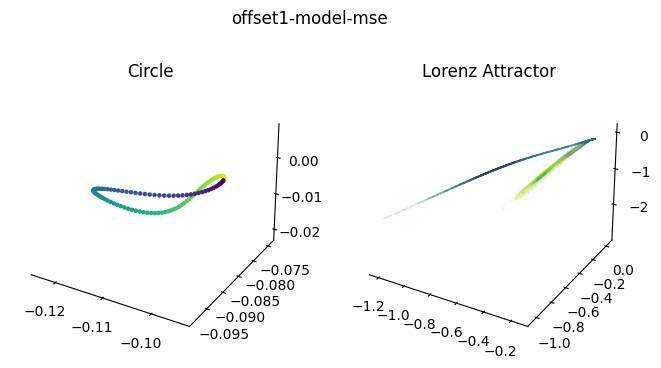

In [12]:
view_model('offset1-model-mse')

### 3. Offset 10-model 

pos:  0.0031 neg:  5.3377 total:  5.3408 temperature:  1.0000: 100%|██████████| 2000/2000 [00:34<00:00, 58.16it/s]
pos:  0.0010 neg:  6.1052 total:  6.1063 temperature:  1.0000: 100%|██████████| 2000/2000 [00:32<00:00, 61.49it/s]
pos:  0.0022 neg:  5.5725 total:  5.5747 temperature:  1.0000: 100%|██████████| 2000/2000 [00:32<00:00, 60.85it/s]
pos:  0.0018 neg:  5.7572 total:  5.7590 temperature:  1.0000: 100%|██████████| 2000/2000 [00:33<00:00, 60.29it/s]


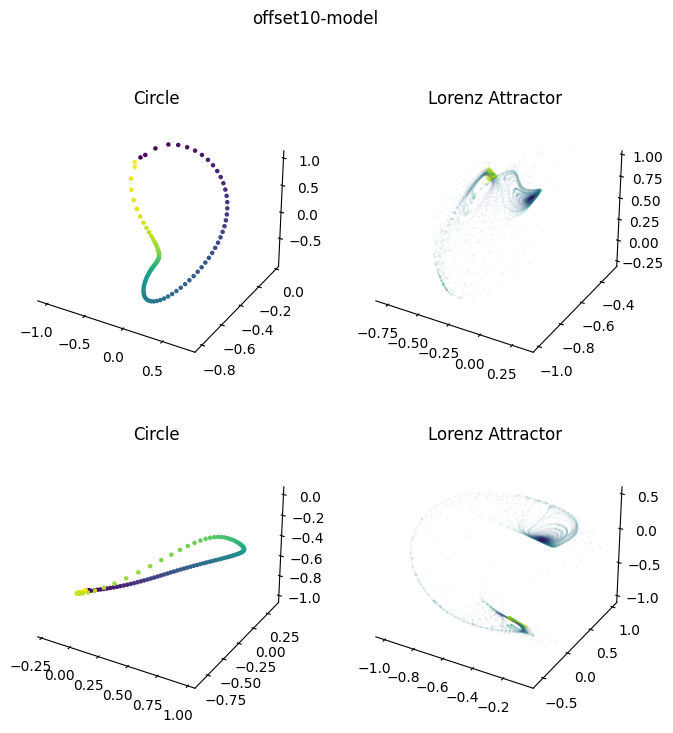

In [13]:
view_model('offset10-model', n_iterations=2)

### 4. All Models

We now make a summary function to analyse all the predefined CEBRA models.

In [14]:
cebra.models.get_options()

['offset10-model',
 'offset10-model-mse',
 'offset5-model',
 'offset1-model-mse',
 'offset1-model',
 'offset1-model-v2',
 'offset1-model-v3',
 'offset1-model-v4',
 'offset1-model-v5',
 'offset40-model-4x-subsample',
 'resample-model',
 'offset20-model-4x-subsample',
 'resample5-model',
 'offset4-model-2x-subsample',
 'resample1-model',
 'supervised10-model',
 'supervised1-model',
 'offset36-model',
 'offset36-model-dropout',
 'offset36-model-more-dropout']

In [15]:
save_dir = os.getcwd()

In [16]:
# takes in  number of iterations for each model
def analyse_models(iter=5):

    # get a list of all the models
    list = cebra.models.get_options()[17:]

    # view the embeddings produced by each model
    for model in list:
        view_model(model_name=model, n_iterations=int(iter))
        plt.savefig(save_dir + os.sep + model + ".png")

pos:  0.0089 neg:  5.3422 total:  5.3511 temperature:  1.0000: 100%|██████████| 2000/2000 [01:24<00:00, 23.77it/s]
pos:  0.0006 neg:  6.2269 total:  6.2275 temperature:  1.0000: 100%|██████████| 2000/2000 [01:24<00:00, 23.65it/s]
pos:  0.0012 neg:  5.8966 total:  5.8979 temperature:  1.0000: 100%|██████████| 2000/2000 [01:25<00:00, 23.42it/s]
pos:  0.0050 neg:  6.1349 total:  6.1400 temperature:  1.0000: 100%|██████████| 2000/2000 [01:41<00:00, 19.79it/s]
pos:  0.0015 neg:  5.5951 total:  5.5966 temperature:  1.0000: 100%|██████████| 2000/2000 [01:40<00:00, 19.81it/s]
pos:  0.0079 neg:  6.0902 total:  6.0981 temperature:  1.0000: 100%|██████████| 2000/2000 [01:41<00:00, 19.77it/s]
pos:  0.0017 neg:  5.6265 total:  5.6282 temperature:  1.0000: 100%|██████████| 2000/2000 [01:41<00:00, 19.66it/s]
pos:  0.0039 neg:  6.2075 total:  6.2114 temperature:  1.0000: 100%|██████████| 2000/2000 [01:41<00:00, 19.68it/s]
pos:  0.0002 neg:  6.1438 total:  6.1440 temperature:  1.0000: 100%|██████████| 

KeyboardInterrupt: 

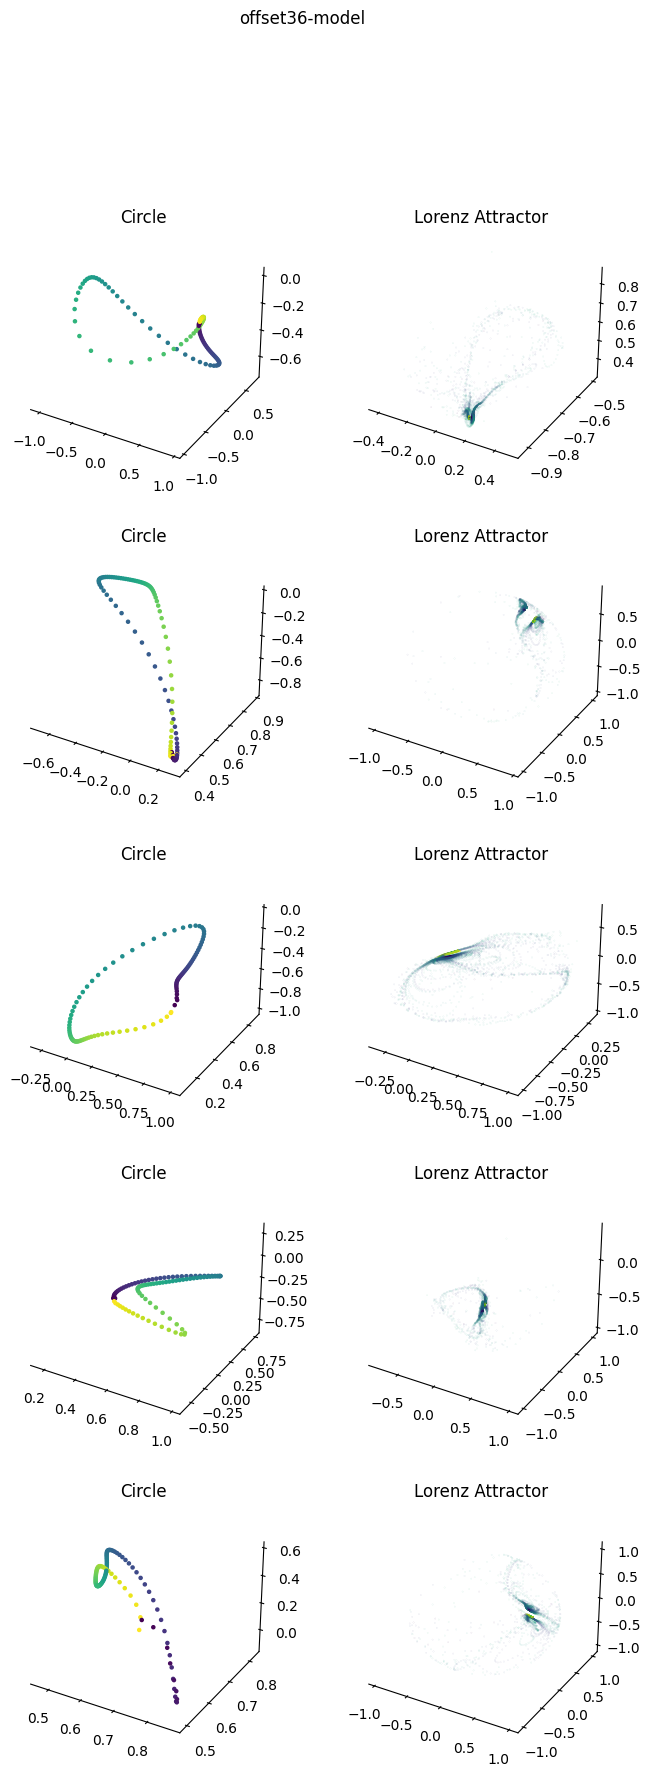

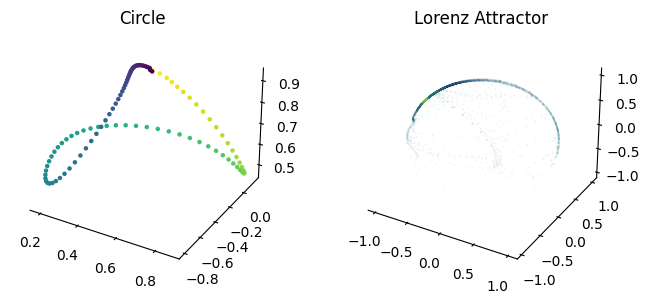

In [17]:
analyse_models()

On subjective viewing of the embeddings produced by the different model architectures, some have stood out for different reasons:

- offset1-model, offset1-model-mse, offset5-model, offset10-model-mse, offset36-model: for recovering the circles (comparatively) consistently
- offset10-model, offset-model: for recovering the circles consistently and getting almost plausible representations of the lorenz attractor.